In [1]:
import numpy as np
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import pipeline
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import pickle
from utils import *
import re



nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger', 'stopwords', 'vader_lexicon'])

[nltk_data] Downloading package punkt to /Users/jairneto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jairneto/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jairneto/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jairneto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jairneto/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jairneto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jairneto/nltk_data...
[nltk_data]   Package wordnet is 

True

In [5]:
letters_dict = get_letters_corpus_dict('/Users/jairneto/Downloads/')

Could not open the url https://www.berkshirehathaway.com/letters/1982.html


2021-04-15 19:48:28,510 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.
2021-04-15 19:48:48,967 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2000ltr.pdf


2021-04-15 19:48:50,800 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2001ltr.pdf


2021-04-15 19:48:51,307 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2002ltr.pdf


2021-04-15 19:48:51,871 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2003ltr.pdf


2021-04-15 19:48:52,356 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2004ltr.pdf


2021-04-15 19:48:52,845 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2005ltr.pdf


2021-04-15 19:48:53,328 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2006ltr.pdf


2021-04-15 19:48:53,792 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2007ltr.pdf


2021-04-15 19:48:54,393 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2008ltr.pdf


2021-04-15 19:48:54,995 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2009ltr.pdf


2021-04-15 19:48:55,723 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2010ltr.pdf


2021-04-15 19:48:56,259 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2011ltr.pdf


2021-04-15 19:48:56,917 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2012ltr.pdf


2021-04-15 19:48:57,864 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2013ltr.pdf


2021-04-15 19:48:58,669 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2014ltr.pdf


2021-04-15 19:48:59,459 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2015ltr.pdf


2021-04-15 19:49:00,182 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2016ltr.pdf


2021-04-15 19:49:00,879 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2017ltr.pdf


2021-04-15 19:49:01,632 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2018ltr.pdf


2021-04-15 19:49:02,704 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.
2021-04-15 19:49:02,908 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.


Could not open the path /Users/jairneto/Downloads/2019ltr.pdf
Could not open the path /Users/jairneto/Downloads/2020ltr.pdf


In [126]:
# Write the dict to a pickle
with open('letters_dict.pickle', 'wb') as handle:
    pickle.dump(letters_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
# Read the dict from a pickle
with open('letters_dict.pickle', 'rb') as handle:
    letters_dict = pickle.load(handle)

In [3]:
frequent_words_list = ['year', 'business', 'berkshire', 'million', 'company', 'u',
                       'billion', 'tax', 'investment', 'share', 'last', 'value',
                       'would', 'many', 'operation', 'market', 'one', 'large', 'p',
                       'make', 'asset', 'also', 'see', 'even', 'well', 'two', 'made',
                       'pre', 'return', 'cost', 'capital', 'may', 'price', 'per', 'first',
                       'annual', 'though', 'however', 'time',
                       'manager', 'money', 'dollar', 'meeting',
                       'interest', 'great', 'group', 'come', 'far',
                       'long', 'worth', 'net', 'report', 'industry', 'put',
                       'contract', 'must', 'yearend', 'day', 'major', 'real', 'since',
                       'let', 'need', 'record', 'good', 'country', 'america', 'period',
                       'average', 'increased', 'home', 'run', 'way',
                       'world', 'second', 'four', 'product', 'largest', 'certain',
                       'financial', 'three',
                       'ago', 'almost', 'american',
                       'amount', 'area', 'b',
                       'believe', 'better', 'blue', 'board',
                       'book', 'borrower', 'brown', 'buffett', 'buyer',
                       'c', 'capacity', 'case', 'cash', 'casualty', 'cat', 'category',
                       'change', 'charge', 'chip', 'charlie',
                       'committee', 'common', 'controlled', 'corporate',
                       'corporation', 'could', 'coupon', 'customer', 'debt',
                       'director',
                       'every',
                       'fee', 'figure', 'find', 'five', 'float',
                       'fund', 'g',
                       'general', 'get', 'give', 'goodwill',
                       'h', 'hathaway', 'helper', 'high', 'holding',
                       'hour', 'housing', 'huge', 'important', 'inc', 'income',
                       'intrinsic',
                       'investor', 'k', 'know', 'le', 'like', 'line', 'look',
                       'low', 'management', 'medium', 'merger',
                       'mr', 'much', 'name', 'national', 'never',
                       'new', 'news', 'non', 'number', 'often', 'operating',
                       'others', 'owned', 'owner', 'ownership', 'page', 'paid',
                       'paper', 'past', 'pay', 'payment', 'people',
                       'preferred', 'premium',
                       'purchase', 'question',
                       'rather', 'ratio',
                       'reported', 'reserve', 'result', 'retained',
                       'rule', 'say',
                       'september', 'service', 'shoe',
                       'star', 'state', 'store', 'subsidiary', 'sunday', 'super',
                       'take', 'ten', 'th',
                       'therefore', 'utility', 'volume',
                       'zero']

In [4]:
## Create a document-term matrix with CountVectorizer
df_letters = None
for k in letters_dict:
    count_v = CountVectorizer(tokenizer=tokenize)
    letter_X = count_v.fit_transform([letters_dict[k]]).toarray()
    if df_letters is None:
        df_letters = pd.DataFrame(letter_X, columns=count_v.get_feature_names(), index=[k])
    else:
        df_letters = df_letters.append(pd.DataFrame(letter_X, columns=count_v.get_feature_names(), index=[k]))

In [5]:
df_heat = None
df_filtered = df_letters.T.query(f"index not in {frequent_words_list}")
for col in df_filtered.columns:
    col = int(col)
    x = df_filtered.sort_values(col, ascending=False)[col]
    if df_heat is None:
        df_heat = x.to_frame()
        df_heat.columns = [col]
    else:
        df_heat[col] = x

In [52]:
columns = df_frequency_heat.columns
n_cols = len(columns)
grouped_df_cols = []
for i in range(0, n_cols, 5):
    j = i + 4
    if j >= n_cols:
        j = n_cols - 1
    grouped_df_cols.append(f'{columns[i]} - {columns[j]}')
grouped_df = pd.DataFrame(columns=grouped_df_cols)

In [53]:
print(grouped_df_cols)

['1977 - 1981', '1982 - 1986', '1987 - 1991', '1992 - 1996', '1997 - 2001', '2002 - 2006', '2007 - 2011', '2012 - 2016', '2017 - 2020']


In [54]:
for i in range(len(grouped_df_cols)):
    begin = i * 5
    end = (i + 1) * 5
    grouped_df[grouped_df_cols[i]] = df_frequency_heat.iloc[:, begin:end].sum(axis=1)

In [6]:
key_words = ['ceo', 'insurance', 'shareholder', 'gain', 'loss', 'stock', 'bond',
             'acquisition', 'portfolio', 'risk', 'sale',
             'discount', 'opportunity']
df_frequency_heat = df_heat.loc[key_words].fillna(0)

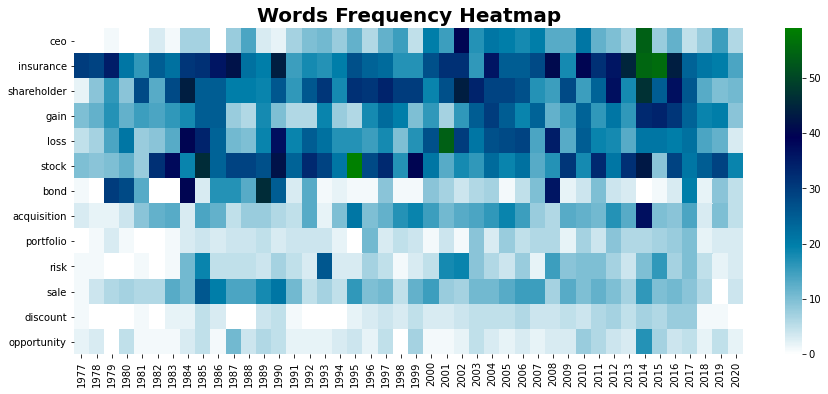

In [7]:
draw_heatmap(df_frequency_heat, cmap='ocean_r', ylabel='', xlabel='', title='Words Frequency Heatmap')

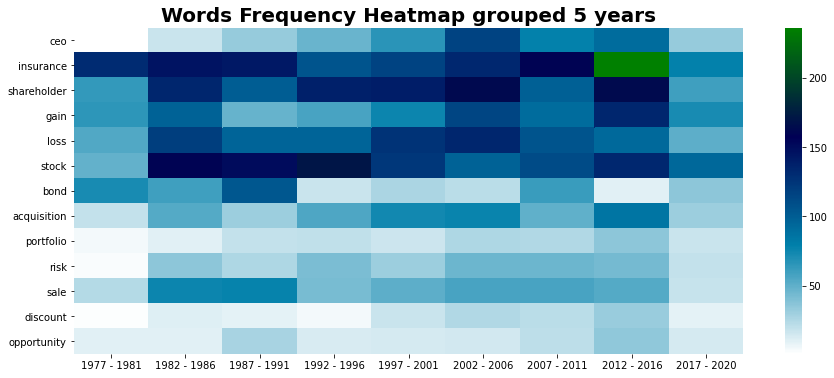

In [55]:
draw_heatmap(grouped_df, cmap='ocean_r', ylabel='', xlabel='', title='Words Frequency Heatmap grouped 5 years')

In [16]:
key_words_2 = ['hedge', 'trade', 'bitcoin', 'blockchain', 'crypto', 'forex', 'options', 'ai',
             'technology', 'esg', 'tesla', 'amazon', 'faang']
a = []
for w in key_words_2:
    try:
        df_heat.loc[w]
        a.append(w)
    except:
        print(w)
# df_frequency_heat_2 = df_heat.loc[key_words_2].fillna(0)

bitcoin
blockchain
crypto
forex
options
ai
esg
tesla
faang


## More frequency analysis

In [8]:
corpus = []
for k in letters_dict:
    corpus.append(letters_dict[k])

In [9]:
tokenized_corpus = []
for text in corpus:
    tokenized_corpus.extend(tokenize(text))

In [10]:
len(tokenized_corpus)

267466

In [11]:
filtered_tokenized_corpus = [w for w in tokenized_corpus if w not in frequent_words_list]

In [12]:
freq_dict = get_most_frequent_combinatation(tokenized_corpus, 10, -1)

In [13]:
for k in freq_dict:
    print(k)
    print(freq_dict[k])

FreqDist_onegram
[('year', 3475), ('business', 3304), ('berkshire', 3105), ('company', 2422), ('earnings', 1972), ('value', 1600), ('would', 1570), ('u', 1483), ('million', 1437), ('share', 1364)]
FreqDist_bigram
[(('last', 'year'), 770), (('per', 'share'), 373), (('book', 'value'), 304), (('pre', 'tax'), 263), (('long', 'term'), 260), (('intrinsic', 'value'), 255), (('net', 'worth'), 236), (('operating', 'earnings'), 225), (('year', 'ago'), 205), (('berkshire', 'share'), 186)]
FreqDist_trigram
[(('pre', 'tax', 'earnings'), 111), (('profit', 'le', 'zero'), 111), (('berkshire', 'hathaway', 'inc'), 103), (('le', 'zero', 'profit'), 103), (('zero', 'profit', 'le'), 103), (('nebraska', 'furniture', 'mart'), 95), (('intrinsic', 'business', 'value'), 86), (('share', 'book', 'value'), 75), (('per', 'share', 'book'), 74), (('shareholder', 'designated', 'contribution'), 66)]
FreqDist_quadgrams
[(('profit', 'le', 'zero', 'profit'), 103), (('le', 'zero', 'profit', 'le'), 103), (('zero', 'profit', 

In [18]:
freq_dict_filtered = get_most_frequent_combinatation(filtered_tokenized_corpus, 20, -1)

In [15]:
for k in freq_dict_filtered:
    print(k)
    print(freq_dict_filtered[k])

FreqDist_onegram
[('earnings', 1972), ('insurance', 1250), ('stock', 1091), ('shareholder', 1064), ('loss', 878), ('gain', 758), ('profit', 667), ('geico', 602), ('rate', 600), ('term', 509)]
FreqDist_bigram
[(('balance', 'sheet'), 158), (('underwriting', 'profit'), 141), (('scott', 'fetzer'), 121), (('coca', 'cola'), 112), (('profit', 'profit'), 106), (('furniture', 'mart'), 104), (('underwriting', 'loss'), 98), (('nebraska', 'furniture'), 95), (('earnings', 'earnings'), 87), (('short', 'term'), 79)]
FreqDist_trigram
[(('nebraska', 'furniture', 'mart'), 95), (('profit', 'profit', 'profit'), 95), (('shareholder', 'designated', 'contribution'), 67), (('designated', 'contribution', 'program'), 37), (('rate', 'compounded', 'annually'), 36), (('present', 'took', 'grown'), 32), (('grown', 'rate', 'compounded'), 31), (('took', 'grown', 'rate'), 30), (('attachment', 'proxy', 'material'), 29), (('washington', 'post', 'fargo'), 27)]
FreqDist_quadgrams
[(('profit', 'profit', 'profit', 'profit'),

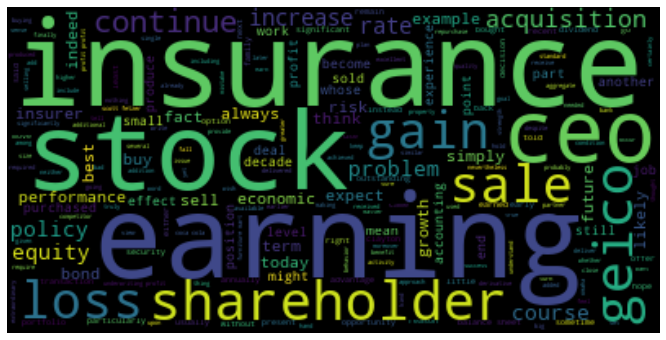

In [16]:
drawn_wordcloud(filtered_tokenized_corpus, 'wordcloud_filtered.png')

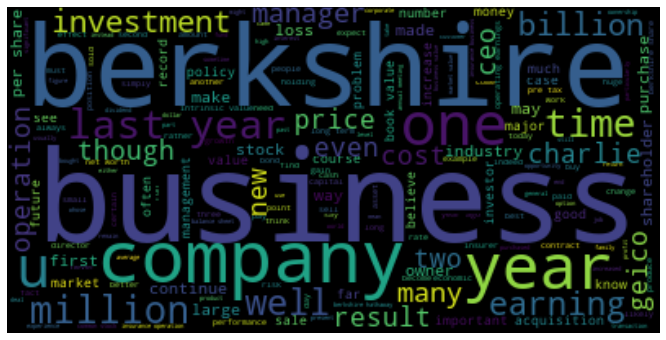

In [17]:
drawn_wordcloud(tokenized_corpus, 'wordcloud_complete.png')

# Sentiment Analysis

In [4]:
from transformers import pipeline
classifier = pipeline('sentiment-analysis')

## Ngrams Sentiment Analysis

In [29]:
df = pd.DataFrame(columns=['type', 'text', 'sentiment', 'score'])
for k in freq_dict_filtered:
    for w, _ in freq_dict_filtered[k]:
        if type(w) == tuple:
            w = ' '.join(w)
        result = classifier(w)
        new_row = {'type': k, 'text': w, 'sentiment':result[0]['label'], 'score':result[0]['score']}
        df = df.append(new_row, ignore_index=True)

In [37]:
df.query("type == 'FreqDist_onegram' and sentiment == 'POSITIVE'")

,type,text,sentiment,score
0,FreqDist_onegram,earnings,POSITIVE,0.999316
1,FreqDist_onegram,insurance,POSITIVE,0.993685
3,FreqDist_onegram,shareholder,POSITIVE,0.997295
5,FreqDist_onegram,gain,POSITIVE,0.999259
6,FreqDist_onegram,profit,POSITIVE,0.999423
8,FreqDist_onegram,rate,POSITIVE,0.981397
9,FreqDist_onegram,term,POSITIVE,0.961170
11,FreqDist_onegram,ceo,POSITIVE,0.981761
12,FreqDist_onegram,acquisition,POSITIVE,0.984089
14,FreqDist_onegram,equity,POSITIVE,0.999136


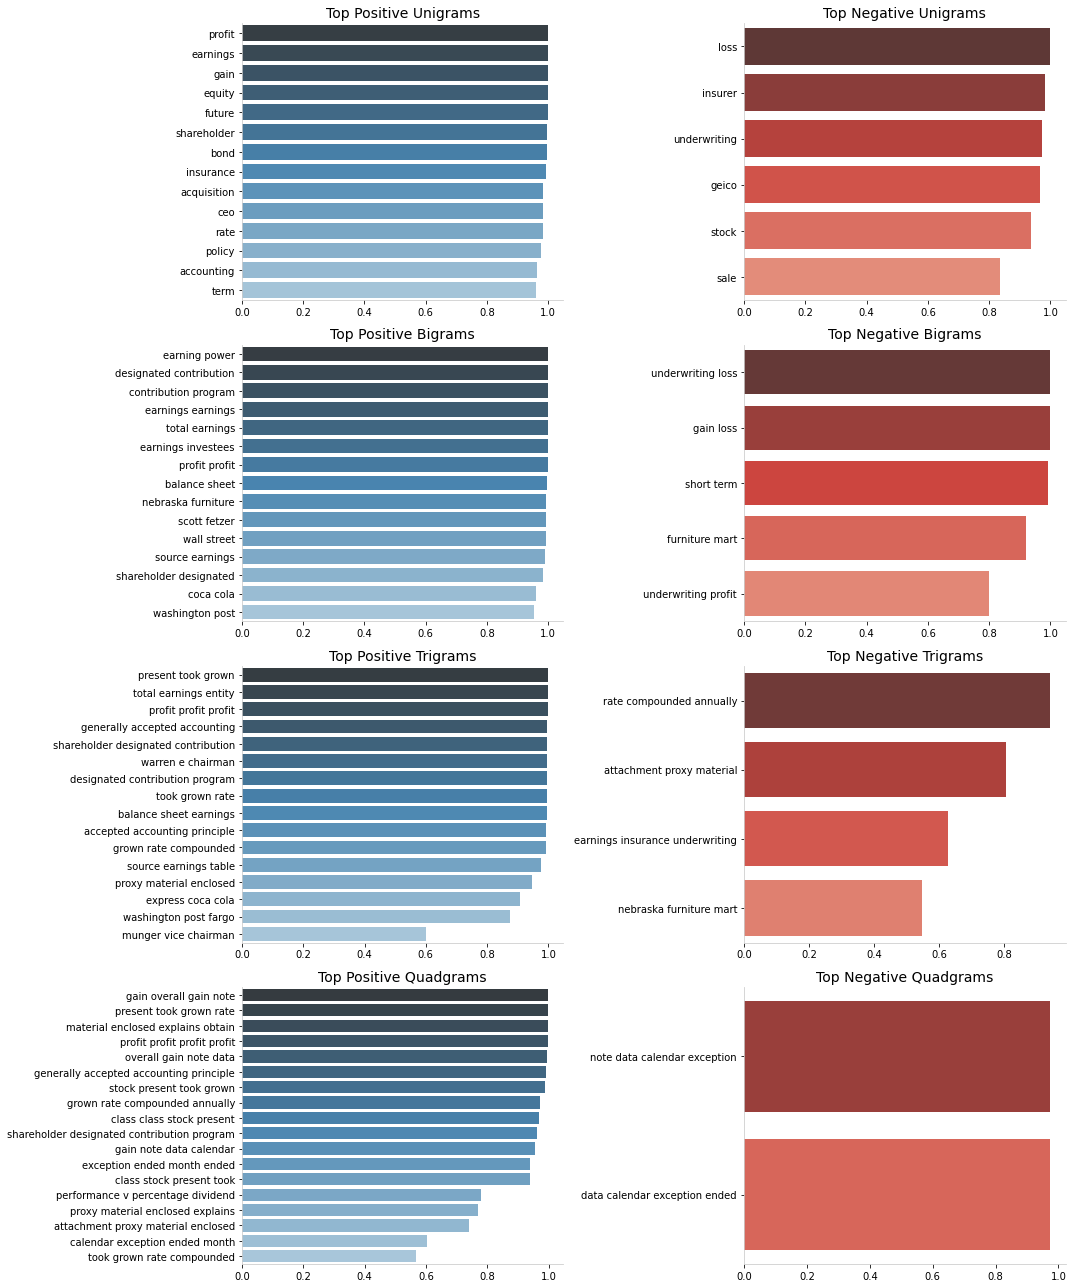

In [48]:
ngram_dict_plot = {
    'Top Positive Unigrams': get_ngram_plot_data(df, 'FreqDist_onegram', 'POSITIVE'),
    'Top Negative Unigrams': get_ngram_plot_data(df, 'FreqDist_onegram', 'NEGATIVE'),
    'Top Positive Bigrams': get_ngram_plot_data(df, 'FreqDist_bigram', 'POSITIVE'),
    'Top Negative Bigrams': get_ngram_plot_data(df, 'FreqDist_bigram', 'NEGATIVE'),
    'Top Positive Trigrams': get_ngram_plot_data(df, 'FreqDist_trigram', 'POSITIVE'),
    'Top Negative Trigrams': get_ngram_plot_data(df, 'FreqDist_trigram', 'NEGATIVE'),
    'Top Positive Quadgrams': get_ngram_plot_data(df, 'FreqDist_quadgrams', 'POSITIVE'),
    'Top Negative Quadgrams': get_ngram_plot_data(df, 'FreqDist_quadgrams', 'NEGATIVE')
}

# Plotting the ngrams analysis
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 18))
i, j = 0, 0
colors = ['Blues_d', 'Reds_d']
for title, ngram_data in ngram_dict_plot.items():
    ax = axs[i, j]
    sns.barplot(x='score', y='text', data=ngram_data, ax=ax, palette=colors[j])
    
    # Customizing plots
    format_spines(ax, right_border=False)
    ax.set_title(title, size=14)
    ax.set_ylabel('')
    ax.set_xlabel('')
    
    # Incrementing the index
    j += 1
    if j == 2:
        j = 0
        i += 1
plt.tight_layout()
plt.show()

## Whole text Sentiment Analysis

In [ ]:
sia_sentiment_analysis_df = get_sentiment_analysis_df(letters_dict, calculate_text_sia, tokenize_sent)

In [97]:
transformers_sentiment_analysis_df = get_sentiment_analysis_df(letters_dict, calculate_text_sentiment_transform, tokenize_sent)

In [5]:
transformers_sentiment_analysis_df

,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
POSITIVE,0.556861,0.418796,0.322228,0.319588,0.324892,0.309835,0.354985,0.331522,0.373907,0.381424,...,0.497369,0.487432,0.50474,0.461852,0.497629,0.447469,0.478325,0.427582,0.461616,0.527134
NEGATIVE,0.443139,0.581204,0.677772,0.680412,0.675108,0.690165,0.645015,0.668478,0.626093,0.618576,...,0.502631,0.512568,0.49526,0.538148,0.502371,0.552531,0.521675,0.572418,0.538384,0.472866


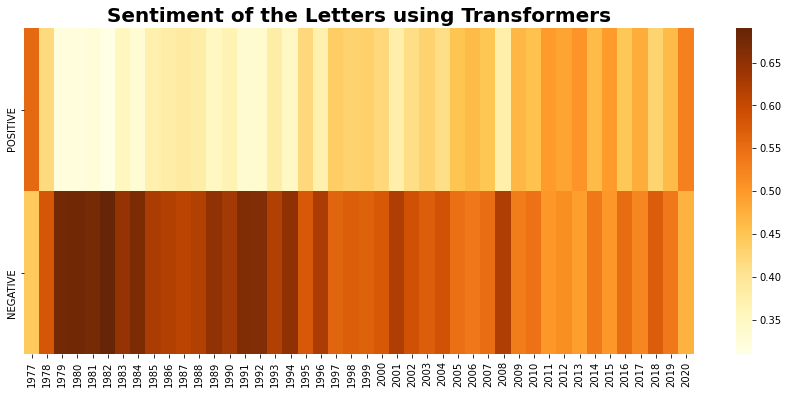

In [8]:
draw_heatmap(transformers_sentiment_analysis_df, title='Sentiment of the Letters using Transformers')

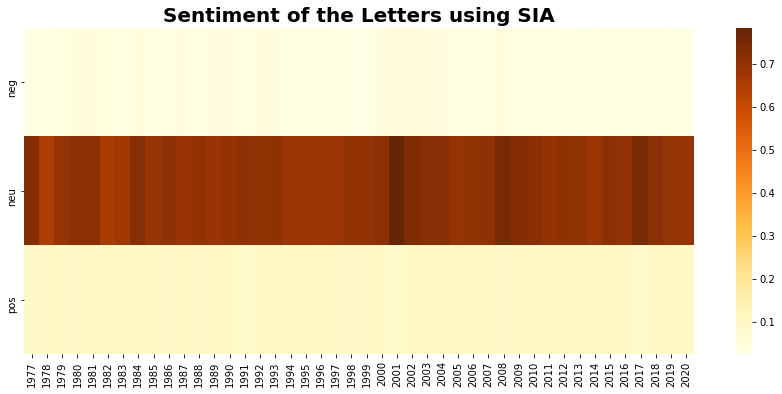

In [39]:
draw_heatmap(sia_sentiment_analysis_df.loc[['neg', 'neu', 'pos']], title='Sentiment of the Letters using SIA')

## QA

In [3]:
nlp = pipeline("question-answering")
sentence_after_regex_2008 = re.sub("[^a-z0-9A-Z\,]", " ", letters_dict[2008])

In [68]:
answer, result, start, end = get_answer_using_qa(nlp, "What led to a dysfunctional credit market?", sentence_after_regex_2008)
print(f"Answer: '{answer}', score: {result}, start: {start}, end: {end}")

Answer: 'a series of life threatening problems', score: 0.5841, start: 7575, end: 7612


In [69]:
result = nlp(question="What produced a paralyzing fear that engulfed the country?", context=sentence_after_regex_2008)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")


Answer: 'the credit crisis', score: 0.4479, start: 7942, end: 7959


In [70]:
result = nlp(question="What generated a paralyzing fear that engulfed the country?", context=sentence_after_regex_2008)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'credit crisis', score: 0.4273, start: 7946, end: 7959


In [71]:
result = nlp(question="Who are the managers of MidAmerican?", context=sentence_after_regex_2008)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'Dave Sokol and Greg Abel', score: 0.9798, start: 18182, end: 18206


In [72]:
result = nlp(question="What are upside-down loans?", context=sentence_after_regex_2008)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'a house is worth less than its mortgage', score: 0.4057, start: 42184, end: 42223


In [4]:
result = nlp(question="How to Profit from a Bear Market?", context=sentence_after_regex_2008)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'millions', score: 0.0078, start: 32253, end: 32261


In [6]:
result = nlp(question="What to invest in when the market crashes?", context=sentence_after_regex_2008)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'derivatives transactions', score: 0.6317, start: 64828, end: 64852


In [7]:
result = nlp(question="What is the best stock to buy?", context=sentence_after_regex_2008)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'underpriced securities', score: 0.9317, start: 17047, end: 17069


In [4]:
complete_corpus = ""
for k in letters_dict:
    complete_corpus += letters_dict[k]
corpus_after_regex = re.sub("[^a-z0-9A-Z\,]", " ", complete_corpus)

In [ ]:
result = nlp(question="What actions to take when a terrorist attack happens?", context=corpus_after_regex)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")